In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from category_encoders import TargetEncoder
from sklearn.metrics import accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import warnings


Bad key text.latex.preview in file C:\Users\spa84\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\spa84\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\spa84\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the default quality parameter.')
You proba

In [2]:
warnings.simplefilter('ignore')

In [3]:
# 데이터 불러오기
df = pd.read_csv('./data/Before_Encoding_5000.csv', encoding='euc-kr')

## 파이프라인
- 데이터 전처리를 파이프 라인으로 진행

In [5]:
# 범주형 변수 리스트 지정
categorical_columns = ['Building_Use', 'Region_Name']
target_column = 'JS_Price'

# JS_Price를 4개의 범주로 나누고 기존 변수 삭제
df['JS_Price_Category'] = pd.cut(df['JS_Price'], bins=5, labels=False)
df.drop('JS_Price', axis=1, inplace=True)

# 선택한 독립변수만 추출
selected_features = [
    'CA_index',
    'Shortest_Distance_to_School',
    'HSP_index',
    'TC_index',
    'IR',
    'SDT_index',
    'UR'
]

# 범주형 열 중에서 선택한 독립 변수에 포함된 열 확인
categorical_columns_exist = list(set(categorical_columns).intersection(set(selected_features)))

# 데이터 분할
X = df[selected_features]
y = df['JS_Price_Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 파이프라인 설정 (타겟 인코딩 포함 여부에 따라 다르게 설정)
if categorical_columns_exist:
    pipeline = [
        ('target_encoder', TargetEncoder(cols=categorical_columns_exist)),  # 타겟 인코딩
        ('scaler', StandardScaler()),  # 수치형 변수 스케일링
        ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),  # 오버샘플링
        ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs'))  # 로지스틱 회귀 모델
    ]
else:
    pipeline = [
        ('scaler', StandardScaler()),  # 수치형 변수 스케일링
        ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),  # 오버샘플링
        ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs'))  # 로지스틱 회귀 모델
    ]

KeyError: 'JS_Price'

## Logistic Regression Analysis

In [5]:
# 파이프라인 생성
model = Pipeline(pipeline)

# 모델 학습
model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 모델 평가 (정확도 계산)
accuracy = accuracy_score(y_test, y_pred)
print(f"로지스틱 회귀 모델 정확도: {accuracy}")

로지스틱 회귀 모델 정확도: 0.582


## 교차검증
- data leakage 확인을 위해 교차검증 실행

In [6]:
# 교차 검증 수행
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(model, X, y, cv=cv)

# 교차 검증 정확도 출력
print("교차 검증 정확도:", cross_val_scores)

# 평균 정확도 계산
mean_accuracy = np.mean(cross_val_scores)
print("평균 정확도:", mean_accuracy)

교차 검증 정확도: [0.575 0.56  0.566 0.524 0.56 ]
평균 정확도: 0.557


## Training and validaion accuracy
- 학습곡선으로 데이터 크기 증가에 따른 훈련데이터와 검증 데이터의 정확도를 그림으로써 모델의 과적합을 시각적으로 확인

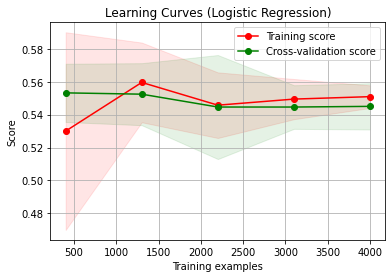

In [11]:
# 학습 곡선 그리기 함수
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# 학습 곡선 그리기
title = "Learning Curves (Logistic Regression)"
plot_learning_curve(model, title, X, y, cv=5, n_jobs=1)
plt.show()

## 변수선택법
- 모델의 복잡성이 줄어든 상태에서 통계적 유의성을 고려하여 변수선택을 위해 다중공선성과 p-value 체크

### 오즈비와 회귀계수

In [13]:
import statsmodels.api as sm

# 다중 로지스틱 회귀 모델 피팅
X_train_sm = sm.add_constant(X_train)
logit_model = sm.MNLogit(y_train, X_train_sm)  # 다중 클래스 로지스틱 회귀
result = logit_model.fit()

# 다중 클래스 로지스틱 회귀 모델의 오즈비와 회귀 계수
print("다중 클래스 로지스틱 회귀 모델의 오즈비:")
print(np.exp(result.params))

# 회귀 계수 출력
print("다중 클래스 로지스틱 회귀 모델의 회귀 계수:")
print(result.params)

Optimization terminated successfully.
         Current function value: 0.333024
         Iterations 13
다중 클래스 로지스틱 회귀 모델의 오즈비:
                                    0         1             2             3
const                        0.000041  0.000003  4.319716e-18  4.066390e-12
CA_index                     1.011196  1.127707  1.584676e+00  1.726226e+00
Shortest_Distance_to_School  0.997381  0.997447  9.962614e-01  9.965672e-01
HSP_index                    0.991517  1.012836  9.666221e-01  1.029951e+00
TC_index                     1.094368  0.968014  9.376447e-01  6.760512e-01
IR                           0.743377  0.820940  6.034070e-01  5.658244e-01
SDT_index                    1.003013  0.997549  1.008783e+00  1.015262e+00
UR                           1.000685  0.749151  9.314784e-01  7.237221e-01
다중 클래스 로지스틱 회귀 모델의 회귀 계수:
                                     0          1          2          3
const                       -10.099890 -12.599744 -39.983342 -26.228265
CA_index           

### 다중공선성

In [9]:
# 변수들의 VIF 계산
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

# 학습에 사용한 독립 변수에 대한 VIF 계산
vif_data = calculate_vif(X_train)

# VIF 출력
print("다중공선성 확인:")
print(vif_data)

다중공선성 확인:
                      Variable          VIF
0                     CA_index  6144.502810
1  Shortest_Distance_to_School     4.832024
2                    HSP_index    66.104614
3                     TC_index  6577.354533
4                           IR     7.291031
5                    SDT_index    44.973492
6                           UR    42.767094


- VIF값 5를 기준으로 높으면 변수에서 제거할 요인으로 본다면 Shortest_Distance_to_School을 제외하고 모두 제거변수

### p-value

In [10]:
# X_train에 상수 항 (intercept) 추가
X_train_sm = sm.add_constant(X_train)

# 로지스틱 회귀 모델의 p-value 계산 (다중 클래스 로지스틱 회귀)
logit_model = sm.MNLogit(y_train, X_train_sm)  # 다중 클래스 로지스틱 회귀
result = logit_model.fit()### p-value
print(result.summary()
     )
# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# 모델 평가 (정확도 계산)
accuracy = accuracy_score(y_test, y_pred)
print(f"모델 정확도 : {accuracy}", '\n')

Optimization terminated successfully.
         Current function value: 0.333024
         Iterations 13
                          MNLogit Regression Results                          
Dep. Variable:      JS_Price_Category   No. Observations:                 4000
Model:                        MNLogit   Df Residuals:                     3968
Method:                           MLE   Df Model:                           28
Date:                Fri, 22 Sep 2023   Pseudo R-squ.:                 0.08873
Time:                        09:33:47   Log-Likelihood:                -1332.1
converged:                       True   LL-Null:                       -1461.8
Covariance Type:            nonrobust   LLR p-value:                 2.451e-39
        JS_Price_Category=1       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         -10.0999      2.520     -4.008      0.000  

- a=0.05일 때, p-value값을 고려하면 모든 변수를 제외한다.

## 최종결론
- Features_Ranking의 17가지 변수 중 상위 10가지를 제외한 7가지 변수에 대해 VIF와 Logistic Regression Analysis를 진행한다.
    - VIF와 Logistit Regression의 p-value값의 공통 제거요인인 'CA_index', 'HSP_index', 'TC_index', 'IR', 'SDT_index', 'UR'을 제거한다.
    - 위의 여섯가지 요인('CA_index', 'HSP_index', 'TC_index', 'IR', 'SDT_index', 'UR')을 변수에서 제거하여 머신러닝을 진행한다.